# Sub Graph 사용

In [1]:
# 랭그래프에선 하나의 노드가 '그래프' 인 하위 그래프를 사용할수 있다.
#  그래프 안에 그래프가 들어가는 형태.
#  모듈화 잘하면 테스트도 편해지고, 재사용성, 확장성 용이.

In [ ]:
# 예제: 기상전문가 그래프를 하위그래프로 사용하는 워크플로

# import

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import httpx
from geopy.geocoders import Nominatim # pip install geopy
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain.chat_models import init_chat_model
from typing import Literal
import json
from IPython.display import Image, display

# 도구

In [4]:
def get_coordinates(city_name: str) -> tuple[float, float]:
    """도시 이름을 받아 위도와 경도를 반환합니다."""
    geolocator = Nominatim(user_agent="weather_app_langgraph")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    raise ValueError(f"좌표를 찾을 수 없습니다: {city_name}")


def get_weather(city_name: str) -> str:
    """도시 이름을 받아 해당 도시의 현재 날씨 정보를 반환합니다."""
    print(f"날씨 조회: {city_name}")
    latitude, longitude = get_coordinates(city_name)
    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"
    response = httpx.get(url)
    response.raise_for_status()
    return json.dumps(response.json())

# 기상 전문자 서브그래프 생성

In [9]:
def create_weather_agent():
    """날씨 관련 질문을 처리하는 전문가 서브그래프를 생성합니다."""
    model = init_chat_model("gpt-4o", model_provider="openai").bind_tools(
        [get_weather]
    )    
    tool_node = ToolNode([get_weather])

    def call_model(state: MessagesState):
        return {"messages": [model.invoke(state["messages"])]}

    graph = StateGraph(MessagesState)
    graph.add_node("call_model", call_model)
    graph.add_node("tool_node", tool_node)

    graph.add_edge(START, "call_model")
    graph.add_conditional_edges(
        "call_model",
        lambda s: "tool_node" if s["messages"][-1].tool_calls else END,
        {
            "tool_node": "tool_node",
            END: END,
        }
    )
    graph.add_edge("tool_node", "call_model")

    return graph.compile()
    

# 메인 그래프 생성

In [10]:
# router() 함수는 노드를 반환하며 사용자의 메시지를 읽어서 어디에 요청을 보낼지 결정하는 역할을 합니다. 
# 예제 코드에서는 단순하게 메시지에 "날씨" 혹은 "기온"이라는 키워드가 있으면 기상 전문가에게, 
# 아니면 일반 에이전트가 처리하도록 했습니다. 

def router(state: MessagesState) -> Literal["weather_expert", "general_agent"]:
    query = state['messages'][-1].content.lower()

    if "날씨" in query or "기온" in query:
        print("라우팅 결정: 기상 전문가에데 위임")
        return "weather_expert"

    print("라우팅 결정: 일반 에이전트가 처리")
    return "general_agent"


In [11]:
# 그래프 생성함수
def create_main_agent(weather_subgraph):
    """질문을 라우팅하고 처리하는 메인 에이전트 그래프를 생성합니다."""
    main_model = init_chat_model("gpt-4o", model_provider="openai")

    workflow = StateGraph(MessagesState)
    workflow.add_node("general_agent", lambda s: {"messages": [main_model.invoke(s['messages'])]})
    workflow.add_node("weather_expert", weather_subgraph)
    workflow.add_conditional_edges(
        START,
        router,
        {
            "weather_expert": "weather_expert",
            "general_agent": "general_agent",
        }
    )
    workflow.add_edge("general_agent", END)
    workflow.add_edge("weather_expert", END)

    return workflow.compile()
    

# 실행

In [12]:
weather_agent = create_weather_agent()
main_agent = create_main_agent(weather_agent)

queries = [
    "성남 날씨 어때?", 
    "잠은 몇시가 자는게 좋을까?",
]

for query in queries:
    print(f"\n--- 질문: {query} ---")
    result = main_agent.invoke({"messages": [HumanMessage(content=query)]})
    print(f"최종 답변: {result['messages'][-1].content}")
    print("-" * 20)



--- 질문: 성남 날씨 어때? ---
라우팅 결정: 기상 전문가에데 위임
날씨 조회: Seongnam
최종 답변: 성남의 현재 날씨는 다음과 같습니다:

- 기온: -8.4°C
- 풍속: 5.5 km/h
- 풍향: 238°
- 낮/밤: 밤 (일몰 후)

추운 날씨이니 따뜻하게 입으세요!
--------------------

--- 질문: 잠은 몇시가 자는게 좋을까? ---
라우팅 결정: 일반 에이전트가 처리
최종 답변: 잠은 개인의 일상 패턴과 신체 리듬에 따라 다르지만, 일반적으로 성인은 매일 7-9시간의 수면을 권장받고 있습니다. 잠자리에 드는 시간은 개인의 기상 시간, 생활 패턴, 개인적인 리듬에 따라 다를 수 있습니다. 아래의 가이드를 참고하면 좋습니다:

1. **일관성**: 매일 같은 시간에 자고 일어나는 것이 중요합니다. 이렇게 하면 생체 시계가 안정되어 수면의 질이 좋아집니다.

2. **바이올로지컬 리듬**: 개인의 자연적인 수면 주기를 파악하여 그에 맞게 잠들 시간을 설정합니다. 만약 아침형 인간이라면 일찍 자는 것이 좋고, 저녁형 인간이라면 조금 늦게 자더라도 충분히 잘 수 있는 시간이 필요합니다.

3. **기상 시간 고려**: 기상 시간을 고정한 후, 수면 시간에 맞춰 잠자리에 드는 것이 좋습니다. 예를 들어, 아침 7시에 일어나야 한다면, 최소한 밤 11시에는 잠자리에 드는 것이 적절합니다.

4. **수면 환경 조성**: 어둡고 조용하며 편안한 환경을 마련하여 수면의 질을 높이세요.

5. **스마트폰 및 전자기기 사용 제한**: 취침 전 최소 30분부터는 스마트폰이나 컴퓨터 사용을 피하는 것이 숙면에 좋습니다.

자신의 몸에 맞는 수면 시간을 찾고, 가능한 한 그 시간을 지키는 습관을 기르면 더욱 건강한 삶을 살 수 있습니다.
--------------------


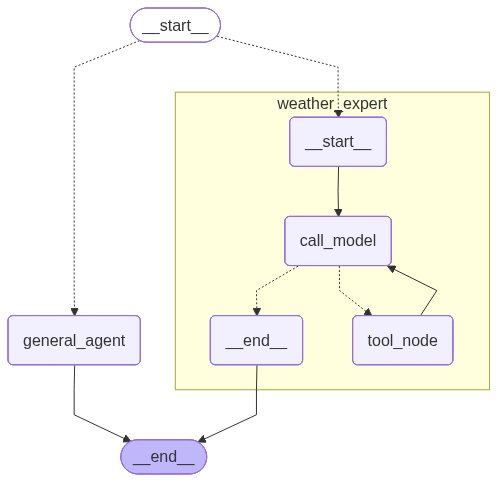

In [14]:
Image(main_agent.get_graph(xray=True).draw_mermaid_png())